In [11]:
import numpy as np
from matplotlib import image
import matplotlib.patches as patches
from pathlib import Path
from typing import Union, Tuple
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec


In [2]:
from models import l_net


model = l_net.L_net(embedding_size=32,
                    lambda_normalization=True)
model.load_weights('weights/lnet_DLV2_emb32_L2_100_L2_WithoutFC.h5')                

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv1-1 (Conv2D)             (None, 128, 128, 16)      160       
_________________________________________________________________
conv1-2 (Conv2D)             (None, 128, 128, 16)      2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2-1 (Conv2D)             (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2-2 (Conv2D)             (None, 64, 64, 32)        9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 32)        0     

In [3]:
def process_path(path: Path):
    """
    This function will preprocess a file img path.
    """
    img = tf.io.read_file(str(path))

    img = tf.io.decode_jpeg(img, channels=1, ratio=2, name="resizeand reshape")

    img = tf.expand_dims(img, 0)
    return img

healthy_img = tf.cast(process_path(Path('example_images/IM-0127-0001.jpeg')), tf.float32)
bacteria_img = tf.cast(process_path(Path('example_images/person338_bacteria_1568.jpeg')), tf.float32)
virus_img = tf.cast(process_path(Path('example_images/person340_virus_698.jpeg')), tf.float32)
healthy_img /= 255
bacteria_img /= 255
virus_img /= 255
print(f'Shape of healthy x-ray: {healthy_img.shape}')
print(f'Shape of bacterial x-ray: {bacteria_img.shape}')
print(f'Shape of viral x-ray: {virus_img.shape}')

Shape of healthy x-ray: (1, 653, 987, 1)
Shape of bacterial x-ray: (1, 376, 620, 1)
Shape of viral x-ray: (1, 716, 880, 1)


In [4]:
def sliding_window_patches(image: tf.Tensor) -> tf.Tensor:

            patches = tf.image.extract_patches(image,
                                               sizes=[1, 128, 128, 1],
                                               strides=[1, 128, 128, 1],
                                               rates=[1, 1, 1, 1],
                                               padding='SAME')
            batch_size, num_windows_height, num_windows_width = patches.shape[0:3]
            new_batch_size = batch_size * num_windows_width * num_windows_height
            patches = tf.reshape(patches, (new_batch_size, 128, 128, 1))
            return patches, num_windows_height, num_windows_width

healthy_patches, hnmh, hnmw = sliding_window_patches(healthy_img)
bacterial_patches, bnmh, bnmw = sliding_window_patches(bacteria_img)
viral_patches, vnmh, vnmw = sliding_window_patches(virus_img)
print(f'Patches shape of healthy x-ray: {healthy_patches.shape}')
print(f'Patches shape of bacterial x-ray: {bacterial_patches.shape}')
print(f'Patches shape of viral x-ray: {viral_patches.shape}')

Patches shape of healthy x-ray: (48, 128, 128, 1)
Patches shape of bacterial x-ray: (15, 128, 128, 1)
Patches shape of viral x-ray: (42, 128, 128, 1)


In [5]:
healthy_recon = model.predict(healthy_patches)
healthy_diff_patches = np.linalg.norm(healthy_patches - healthy_recon, axis=3)
healthy_diff_patches *= 1.0/healthy_diff_patches.max()
bacterial_recon = model.predict(bacterial_patches)
bacterial_diff_patches = np.linalg.norm(bacterial_patches - bacterial_recon, axis=3)
bacterial_diff_patches *= 1.0/bacterial_diff_patches.max()
viral_recon = model.predict(viral_patches)
viral_diff_patches = np.linalg.norm(viral_patches - viral_recon, axis=3)
viral_diff_patches *= 1.0/viral_diff_patches.max()

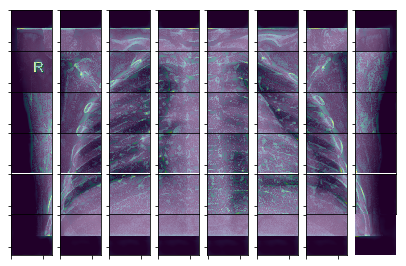

In [24]:
fig, axs = plt.subplots(int(hnmh), int(hnmw))
fig.tight_layout()
for i in range(int(hnmh)):
    for j in range(int(hnmw)):
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i, j].set_aspect('equal')
        plt.subplots_adjust(wspace=0, hspace=0)
        axs[i, j].imshow(np.squeeze(healthy_patches[(i*hnmw)+j, :, :], axis=3), cmap='gray')
        axs[i, j].imshow(healthy_diff_patches[(i*hnmw)+j, :, :], alpha=0.5)
        plt.axis('off')

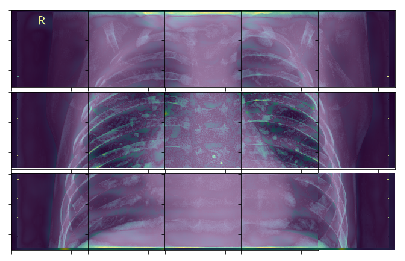

In [25]:
fig, axs = plt.subplots(int(bnmh), int(bnmw))
fig.tight_layout()
for i in range(int(bnmh)):
    for j in range(int(bnmw)):
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i, j].set_aspect('equal')
        plt.subplots_adjust(wspace=0, hspace=0)
        axs[i, j].imshow(np.squeeze(bacterial_patches[(i*bnmw)+j, :, :], axis=3), cmap='gray')
        axs[i, j].imshow(bacterial_diff_patches[(i*bnmw)+j, :, :], alpha=0.5)
        plt.axis('off')

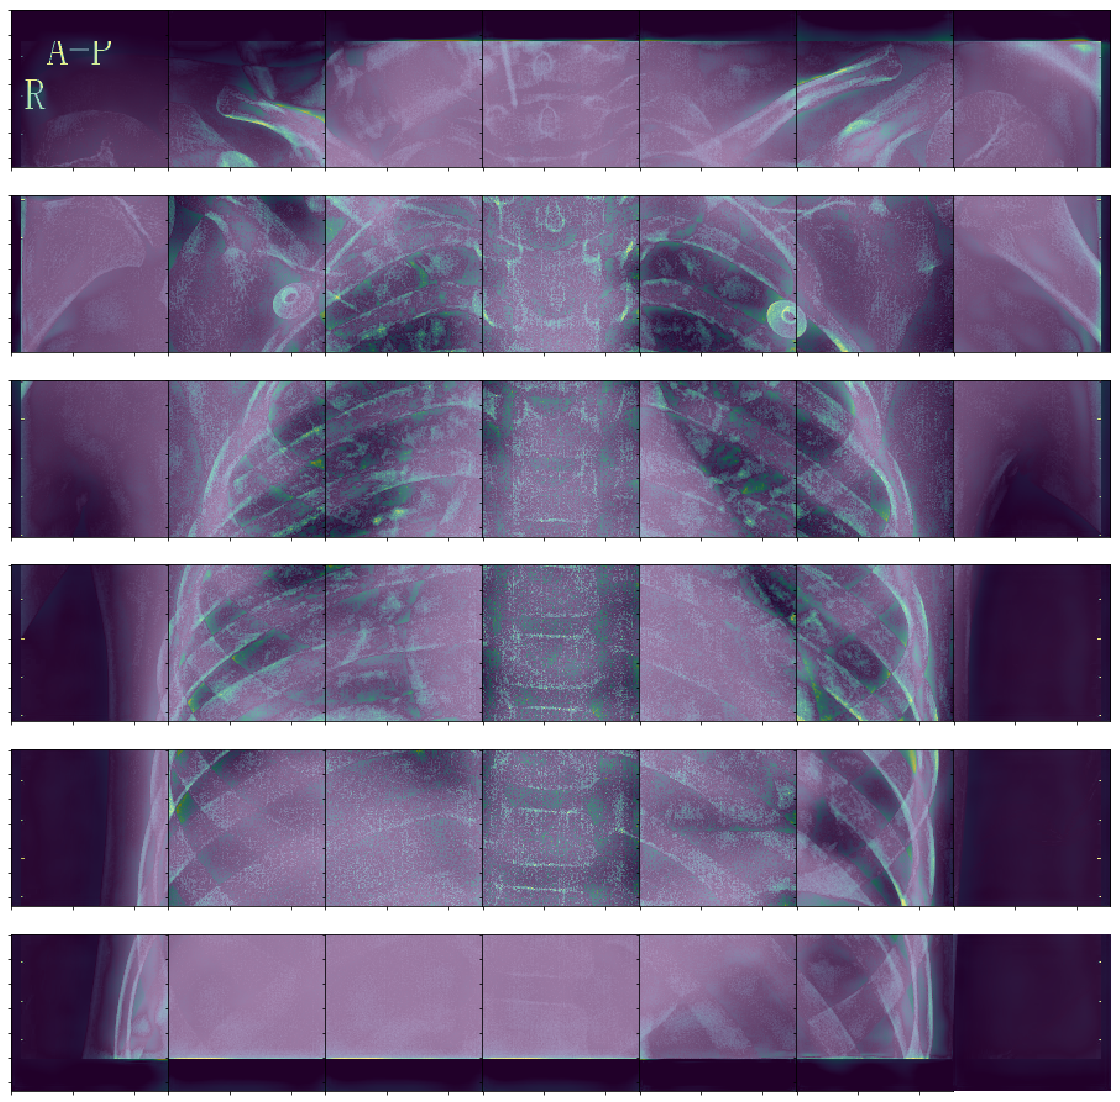

In [28]:
fig, axs = plt.subplots(int(vnmh), int(vnmw), figsize=(16,16))
fig.tight_layout()
gs1 = gridspec.GridSpec(vnmh, vnmw)
gs1.update(wspace=0.025, hspace=0.05)
for i in range(int(vnmh)):
    for j in range(int(vnmw)):
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i, j].set_aspect('equal')
        plt.subplots_adjust(wspace=0, hspace=0)
        axs[i, j].imshow(np.squeeze(viral_patches[(i*vnmw)+j, :, :], axis=3), cmap='gray')
        axs[i, j].imshow(viral_diff_patches[(i*vnmw)+j, :, :], alpha=0.5)
        plt.axis('off')